In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns

In [2]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
x = np.tanh(y) + z
ex_1 = torch.vstack([x, y]).T

In [3]:
y = -6 * torch.rand(100000) + 3
z = np.random.normal(0,np.sqrt(0.05), size = 100000)
x = torch.tanh(y+z)
ex_2 = torch.vstack([x, y]).T

In [4]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
z = torch.tensor(z)
x = z*torch.tanh(y)
ex_3 = torch.vstack([x, y]).T

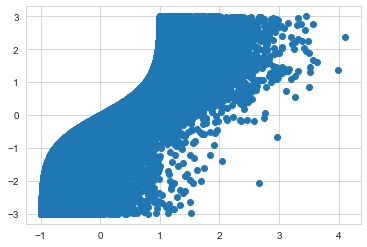

In [216]:
plt.scatter(ex_1[:,0], ex_1[:,1])

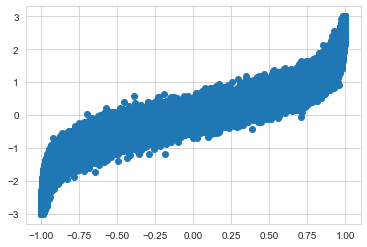

In [217]:
plt.scatter(ex_2[:,0], ex_2[:,1])

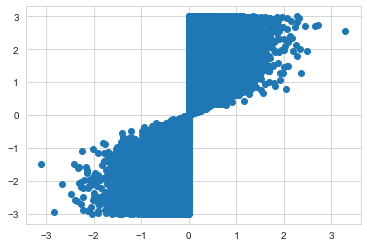

In [218]:
plt.scatter(ex_3[:,0], ex_3[:,1])

In [5]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.mlp = nn.Sequential(
            nn.Linear(3, int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/16), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/16), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), 2, bias=True)
        )
    
    def forward(self, x):
        t = x[:, 2]
        x = self.mlp(x)
        x = x / self.marginal_prob_std(t)[:, None]
        return x

In [6]:
#@title Set up the SDE

device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.
    
    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [63]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [28]:
epochs = 300
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = tanh_data
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-17-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


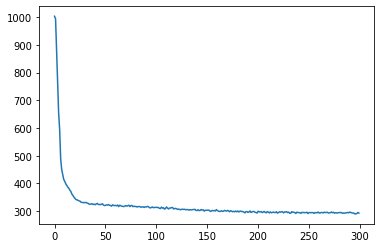

In [29]:
plt.plot(losses)

In [8]:
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)

In [8]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cpu',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)      

    # The last step does not include any noise
    return x_mean

In [64]:
#@title Sampling (double click to expand or collapse)

## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ex_1.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 10000 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-17-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-17-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


In [31]:
sum(p.numel() for p in score_model.parameters())

6006

(-3.2, 3.2)

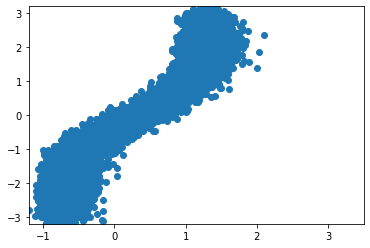

In [65]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

(-3.2, 3.2)

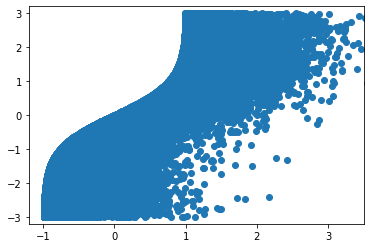

In [33]:
plt.scatter(ex_1[:,0], ex_1[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

In [135]:
#training ex_2
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ex_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-17-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


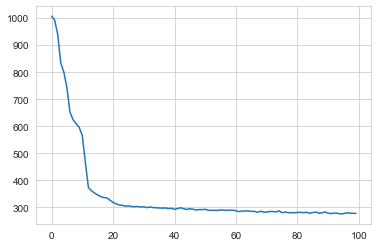

In [136]:
plt.plot(losses)

In [137]:
#@title Sampling (double click to expand or collapse)

## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ex_2.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 10000 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-17-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-17-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


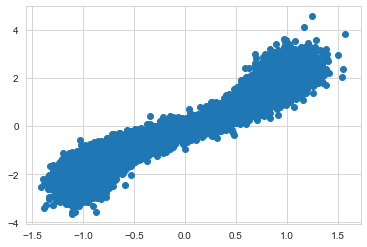

In [138]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

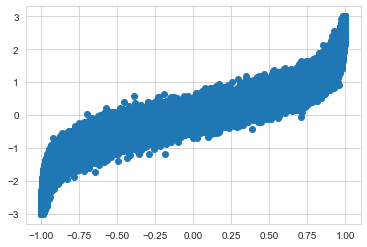

In [139]:
plt.scatter(ex_2[:,0], ex_2[:,1])

In [71]:
#training ex_3
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ex_3.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-17-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


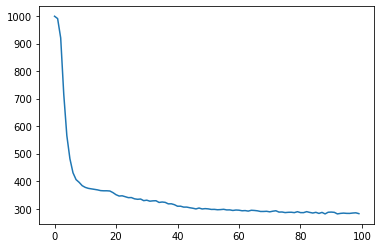

In [72]:
plt.plot(losses)

In [158]:
#@title Sampling (double click to expand or collapse)

## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ex_3.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 10000 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-17-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-17-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


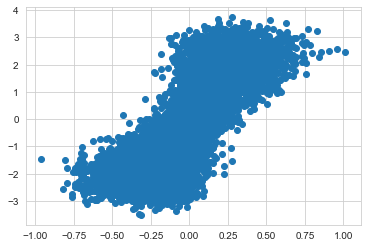

In [159]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

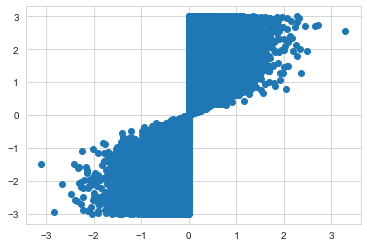

In [160]:
plt.scatter(ex_3[:,0], ex_3[:,1])

<hr style="border:2px solid black">

# CDE tailored conditional method

Have a bunch of training points (x,y). Then only forward diffuse the x components, so we get to (x_N, y). Then train NN to approximate the score with inputs (x_t, y, t), and the same loss as the unconditional method.

In [9]:
def CDE_loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    y = torch.reshape(x[:,1], (x.shape[0], 1))
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    perturbed_x = torch.hstack([perturbed_x,y])
    perturbed_x = perturbed_x[:, [0,2]]
    
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [10]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  1000#@param {'type':'integer'}
def CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=1000, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, device=device) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    x = torch.hstack([init_x, y_obs])
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps): 

            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 
            
            x = torch.hstack([x,y_obs])
            x = x[:, [0,2]]
            
    # Do not include any noise in the last sampling step.
    return mean_x

In [15]:
actual_samples_pos = np.random.gamma(1,0.3, size = 10000) + np.tanh(1.2)
actual_samples_0 = np.random.gamma(1,0.3, size = 10000) + np.tanh(0)
actual_samples_neg = np.random.gamma(1,0.3, size = 10000) + np.tanh(-1.2)

In [31]:
actual_samples_pos_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 10000) + 1.2)
actual_samples_0_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 10000) + 0)
actual_samples_neg_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 10000) - 1.2)

In [32]:
actual_samples_pos_3 = np.random.gamma(1,0.3, size=10000) * np.tanh(1.2)
actual_samples_neg_3 = np.random.gamma(1,0.3, size=10000) * np.tanh(-1.2)

## Example 1

In [20]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'cde_1.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-6-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


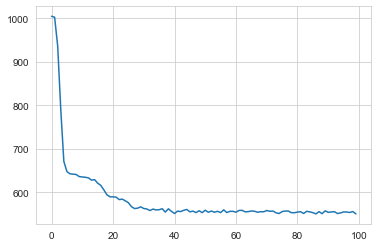

In [21]:
plt.plot(losses)

In [22]:
ckpt = torch.load('cde_1.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [23]:
cde_samples_0 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32))
cde_samples_pos = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))
cde_samples_neg = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

<ipython-input-6-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-6-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

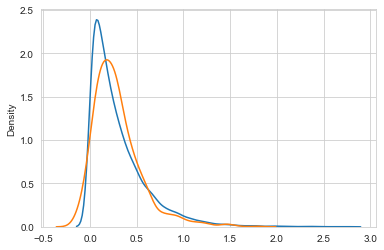

In [24]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_0)
sns.kdeplot(cde_samples_0[:,0])

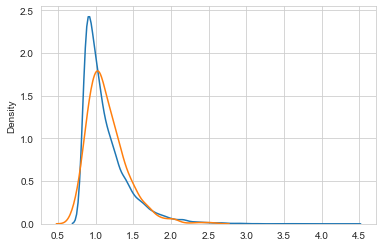

In [25]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cde_samples_pos[:,0])

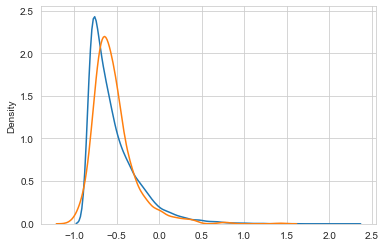

In [26]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cde_samples_neg[:,0])

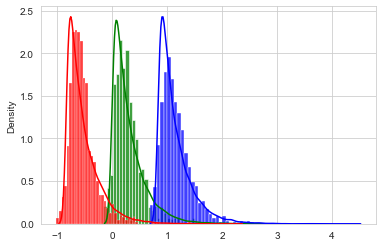

In [27]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cde_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cde_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cde_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [ ]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'cde_2.pth')
    losses.append(avg_loss / num_items)

In [ ]:
plt.plot(losses)

In [28]:
ckpt = torch.load('cde_2.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [29]:
cde_samples_0_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32))
cde_samples_pos_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))
cde_samples_neg_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

<ipython-input-6-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-6-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

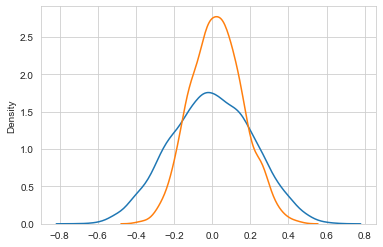

In [33]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cde_samples_0_2[:,0])

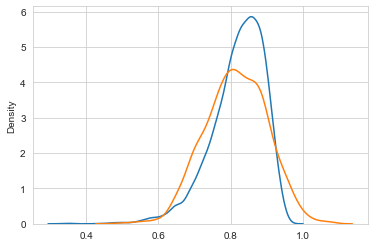

In [34]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cde_samples_pos_2[:,0])

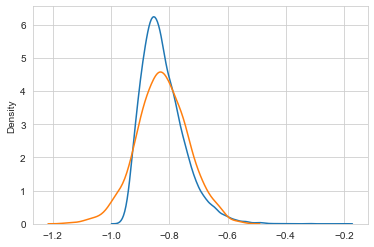

In [35]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cde_samples_neg_2[:,0])

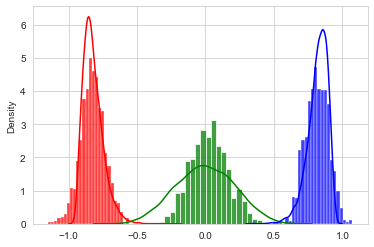

In [36]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cde_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cde_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cde_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [ ]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'cde_3.pth')
    losses.append(avg_loss / num_items)

In [ ]:
plt.plot(losses)

In [37]:
ckpt = torch.load('cde_3.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [38]:
cde_samples_pos_3 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))
cde_samples_neg_3 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

<ipython-input-6-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-6-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

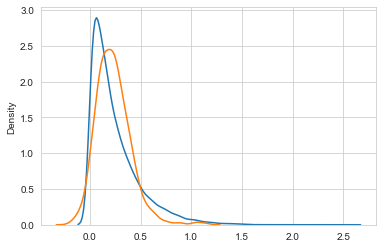

In [39]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cde_samples_pos_3[:,0])

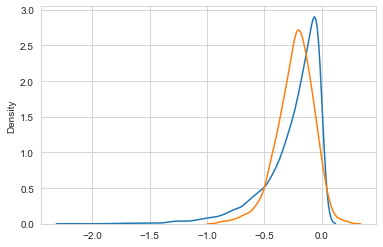

In [40]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cde_samples_neg_3[:,0])

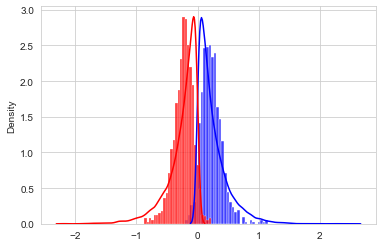

In [41]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cde_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cde_samples_neg_3[:,0], stat = 'density', color = 'red')

<hr style="border:2px solid black">

# CDiffE replacement method

I think, in the case of simulating x|y for this synthetic example, the training stays the same. The difference comes in the sampling. For a given y and timestep t, diffuse y to y_t by the standard forward diffusion. Then at each step of the SDE solver, replace the y value with the diffused y_t.

In [42]:
def get_y_t(y_obs, t):
    std = marginal_prob_std_fn(t)
    z = torch.randn_like(y_obs)
    perturbed_y = y_obs + z * std[:, None]
    return perturbed_y

In [110]:
def get_diffused_y(y_obs, timesteps):
    timesteps = torch.flip(timesteps, [0])
    diffused_y = [y_obs]
    num_steps = timesteps.shape[0]
    dt = 1 / num_steps
    g = diffusion_coeff_fn(timesteps)
    for i in range(num_steps):
        g_i = g[i]
        z = np.random.normal(0,1)
        y_i = diffused_y[-1] + g_i * np.sqrt(dt) * z
        diffused_y.append(y_i)
    return diffused_y

In [119]:
diff_y = get_diffused_y(torch.tensor(3, dtype = torch.float32), torch.linspace(1, 1e-3, 1000, device=device))

<ipython-input-6-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


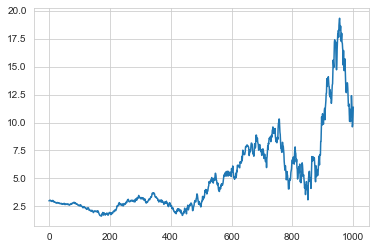

In [120]:
plt.plot(diff_y)

In [136]:
num_steps =  1000
def CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=1000, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    diffused_y = get_diffused_y(y_obs, time_steps)
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps): 

            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 
            
            y_obs_t = get_y_t(y_obs, batch_time_step)
            print(time_step / step_size)
            y_obs_t = diffused_y[time_step]
            x = torch.hstack([x,y_obs_t])
            x = x[:, [0,2]]
            

    # Do not include any noise in the last sampling step.
    return mean_x

## Example 1

In [122]:
ckpt = torch.load('ex_1.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [137]:
cdiffe_samples_0 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32))

cdiffe_samples_neg = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

cdiffe_samples_pos = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))

<ipython-input-6-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-6-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(1000.0129)


TypeError: only integer tensors of a single element can be converted to an index

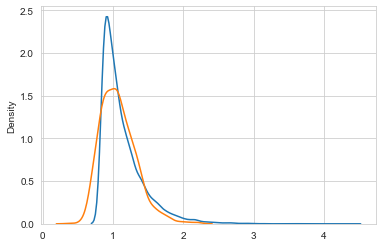

In [46]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cdiffe_samples_pos[:,0])

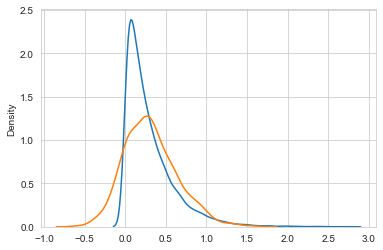

In [47]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_0)
sns.kdeplot(cdiffe_samples_0[:,0])

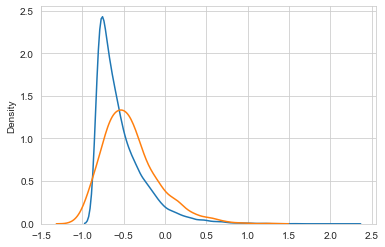

In [48]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cdiffe_samples_neg[:,0])

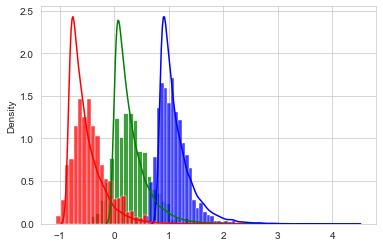

In [49]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cdiffe_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cdiffe_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cdiffe_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [50]:
ckpt = torch.load('ex_2.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [51]:
cdiffe_samples_0_2 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32))

cdiffe_samples_neg_2 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

cdiffe_samples_pos_2 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))

<ipython-input-6-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-6-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

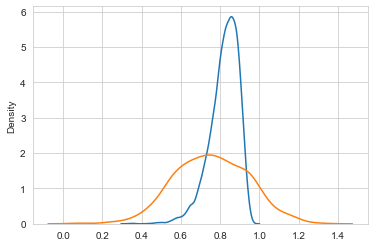

In [52]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cdiffe_samples_pos_2[:,0])

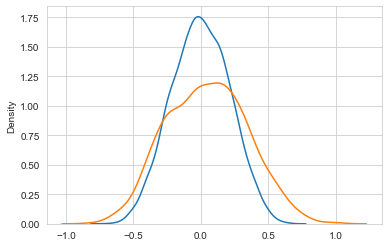

In [53]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cdiffe_samples_0_2[:,0])

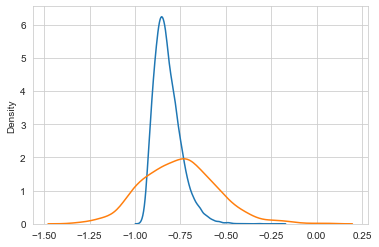

In [54]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cdiffe_samples_neg_2[:,0])

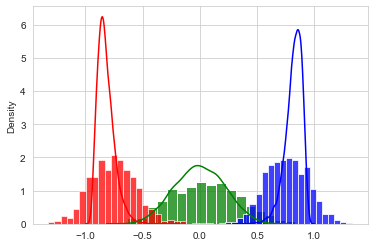

In [55]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cdiffe_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cdiffe_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cdiffe_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [56]:
ckpt = torch.load('ex_3.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [57]:
cdiffe_samples_neg_3 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

cdiffe_samples_pos_3 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))

<ipython-input-6-c03a74537160>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-6-c03a74537160>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

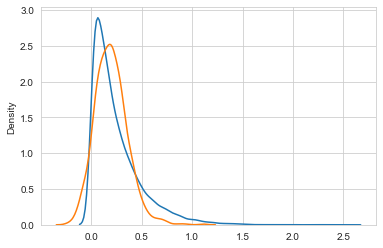

In [58]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cdiffe_samples_pos_3[:,0])

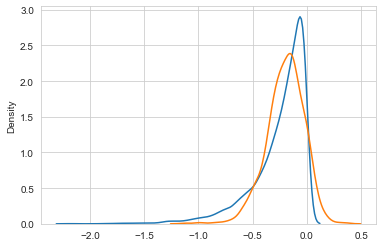

In [59]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cdiffe_samples_neg_3[:,0])

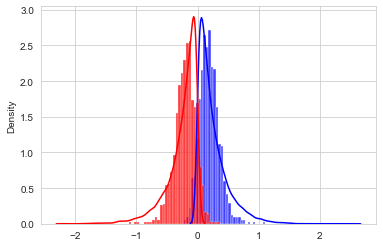

In [60]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cdiffe_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cdiffe_samples_neg_3[:,0], stat = 'density', color = 'red')

<hr style="border:2px solid black">

# SMCDiff method

Similar to the replacement method, but need to add SMC step that looks forward one time step to the diffused condition y_{t-1} to reweight the K samples by the probability p(y_{t-1} | x_t, y_t)